In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

In [25]:
import os
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt

def compute_cap_transmission(image, omega=0.95):
    image = image.astype(np.float32) / 255.0
    hsv = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2HSV)
    brightness = hsv[:, :, 2] / 255.0
    saturation = hsv[:, :, 1] / 255.0
    beta = np.max(brightness) + 1e-5
    transmission = 1 - omega * (beta - saturation)
    return np.clip(transmission, 0, 1)

def compute_dcp_transmission(image, omega=0.95, patch_size=15):
    image = image.astype(np.float32) / 255.0
    min_channel = np.min(image, axis=2)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (patch_size, patch_size))
    dark_channel = cv2.erode(min_channel, kernel)
    transmission = 1 - omega * dark_channel
    return np.clip(transmission, 0, 1)

def compute_haze_line_transmission(image, omega=0.95):
    image = image.astype(np.float32) / 255.0
    mean_intensity = np.mean(image, axis=2)
    beta = np.max(mean_intensity) + 1e-5
    transmission = 1 - omega * (beta - mean_intensity)
    return np.clip(transmission, 0, 1)

def create_guidance_image(image, omega=0.95, patch_size=15):
    cap_transmission = compute_cap_transmission(image, omega)
    dcp_transmission = compute_dcp_transmission(image, omega, patch_size)
    haze_line_transmission = compute_haze_line_transmission(image, omega)
    guidance_image = (cap_transmission + dcp_transmission + haze_line_transmission) / 3.0
    return guidance_image

In [ ]:


def process_and_save_images(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for filename in os.listdir(input_dir):
        if filename.endswith(".JPG") or filename.endswith(".jpg"):
            image_path = os.path.join(input_dir, filename)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            guidance_image = create_guidance_image(image)
            
            output_path = os.path.join(output_dir, filename)
            cv2.imwrite(output_path, (guidance_image * 255).astype(np.uint8))
            print(f"Processed and saved: {output_path}")

# Process train and test datasets
process_and_save_images("dataset/base/train", "dataset/guided/train")
process_and_save_images("dataset/base/test", "dataset/guided/test")


Processed and saved: dataset/guided/train/1.jpg
Processed and saved: dataset/guided/train/10.jpg
Processed and saved: dataset/guided/train/100.jpg
Processed and saved: dataset/guided/train/10003688883_be11839091_z.jpg
Processed and saved: dataset/guided/train/10020320283_83b1514ef4_z.jpg
Processed and saved: dataset/guided/train/100309892_94978cd79e_z.jpg
Processed and saved: dataset/guided/train/100412171_55555c1ce0_z.jpg
Processed and saved: dataset/guided/train/101.jpg
Processed and saved: dataset/guided/train/101039_5ab416185b_z.jpg
Processed and saved: dataset/guided/train/102.jpg
Processed and saved: dataset/guided/train/10278173383_990d01a5eb_z.jpg
Processed and saved: dataset/guided/train/10367996104_44d1937338_z.jpg
Processed and saved: dataset/guided/train/1055104210_c386d6111c_z.jpg
Processed and saved: dataset/guided/train/10560349313_689e068235_z.jpg
Processed and saved: dataset/guided/train/10677419946_15c3d79e45_z.jpg
Processed and saved: dataset/guided/train/10750317316

## Utility Functions

In [33]:
def getStructuringElement(shape, ksize):
    if shape == 0:  
        return np.ones(ksize, dtype=np.uint8)

def erode(image, kernel):
    """Erosion operation using custom structuring element."""
    """Grayscale input image and binary kernel."""
    k_h, k_w = kernel.shape
    pad_h, pad_w = k_h // 2, k_w // 2
    
    # Pad the image to handle border effects
    padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant', constant_values=255)
    eroded_image = np.zeros_like(image)

    # Perform erosion
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded_image[i:i+k_h, j:j+k_w]
            eroded_image[i, j] = np.min(region[kernel == 1])  # Apply erosion
    
    return eroded_image

## Dark Channel

In [34]:
def dark_channel(img, size=15):
    """Computes the dark channel of an image."""
    min_channel = np.min(img, axis=2)  # Find the minimum across color channels
    kernel = getStructuringElement(0, (size, size))  # Custom structuring element
    dark = erode(min_channel, kernel)  # Custom erosion function
    return dark

## Atmospheric Light

In [35]:
def atmospheric_light(img, dark):
    """Estimates the atmospheric light by finding the brightest pixels in the dark channel."""
    h, w = img.shape[:2]
    num_pixels = h * w // 1000  # Take top 0.1% brightest pixels
    dark_vec = dark.reshape(h * w)
    img_vec = img.reshape(h * w, 3)
    indices = np.argsort(dark_vec)[-num_pixels:]  # Get indices of top pixels
    atmo_light = np.mean(img_vec[indices], axis=0)  # Compute mean of brightest pixels
    return atmo_light

## Transmission Estimate

In [36]:
def transmission_estimate(img, atmo_light, omega=0.95, size=15):
    """Estimates the transmission map."""
    norm_img = img / atmo_light
    transmission = 1 - omega * dark_channel(norm_img, size)
    return transmission

## Recover Image

In [38]:
def recover_image(img, t, atmo_light, t0=0.1):
    """Recovers the haze-free image using the estimated transmission map."""
    t = np.maximum(t, t0)  # Avoid division by zero
    J = (img - atmo_light) / t[:, :, None] + atmo_light
    return np.clip(J, 0, 1)

def guided_filter(I, p, r, eps):
    """Guided filter for refining the transmission map."""
    mean_I = cv2.boxFilter(I, cv2.CV_64F, (r, r))
    mean_p = cv2.boxFilter(p, cv2.CV_64F, (r, r))
    corr_I = cv2.boxFilter(I * I, cv2.CV_64F, (r, r))
    corr_Ip = cv2.boxFilter(I * p, cv2.CV_64F, (r, r))

    var_I = corr_I - mean_I * mean_I
    cov_Ip = corr_Ip - mean_I * mean_p

    a = cov_Ip / (var_I + eps)
    b = mean_p - a * mean_I

    mean_a = cv2.boxFilter(a, cv2.CV_64F, (r, r))
    mean_b = cv2.boxFilter(b, cv2.CV_64F, (r, r))

    q = mean_a * I + mean_b
    return q

def dehaze(img_path):
    """Complete dehazing pipeline using Dark Channel Prior."""
    img = cv2.imread(img_path) / 255.0  # Normalize image
    dark = dark_channel(img)
    atmo_light = atmospheric_light(img, dark)
    transmission = transmission_estimate(img, atmo_light)
    
    # Refining transmission map using guided filter
    gray_img = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY) / 255.0
    refined_t = guided_filter(gray_img, transmission, r=60, eps=1e-3)
    
    dehazed_img = recover_image(img, refined_t, atmo_light)
    return (dehazed_img * 255).astype(np.uint8)

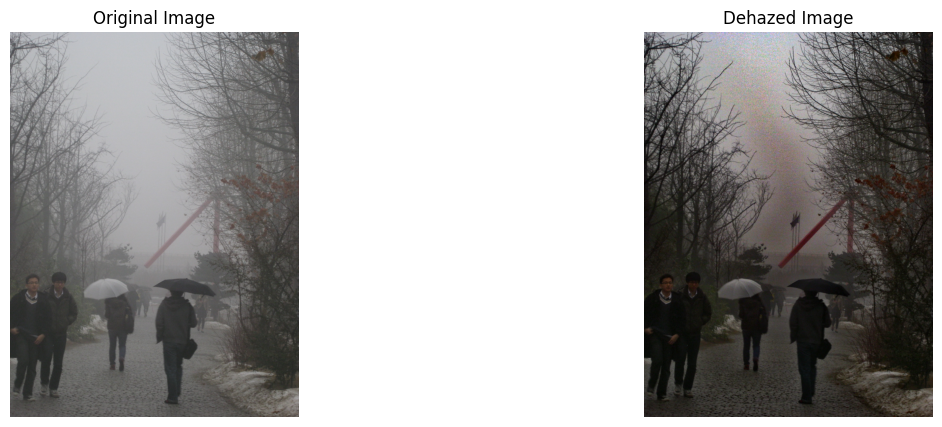

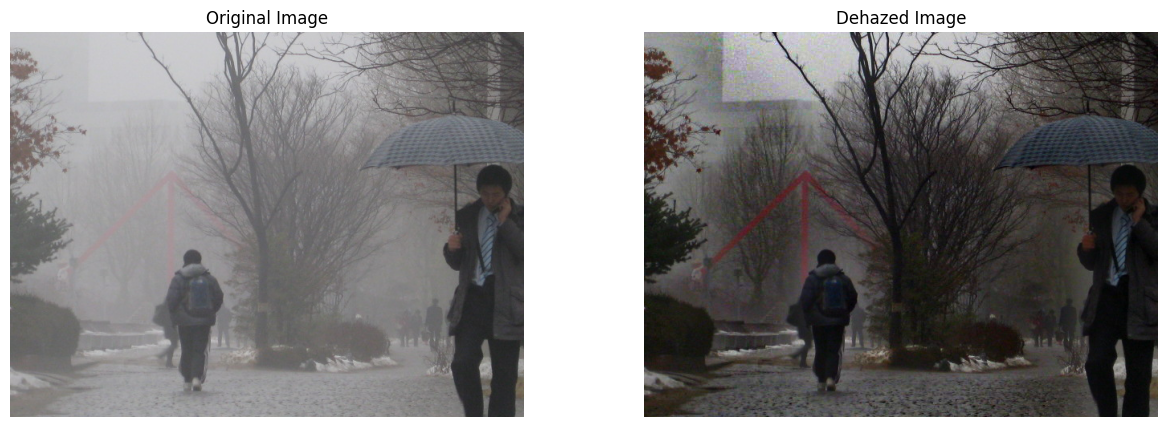

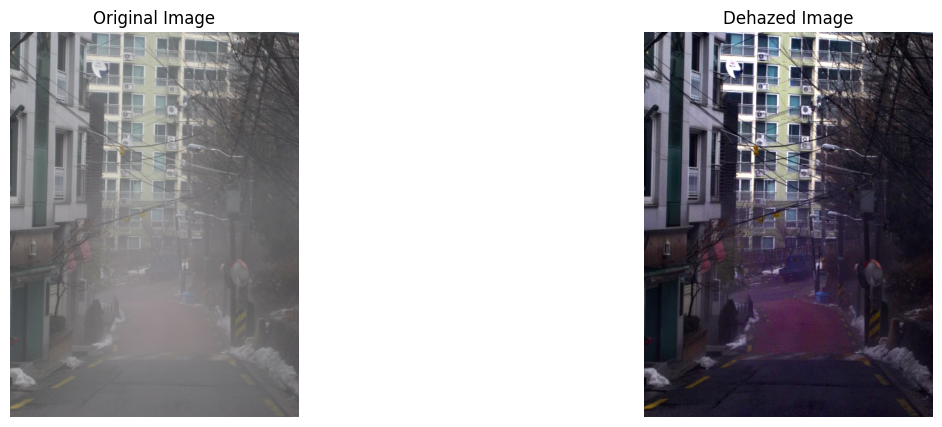

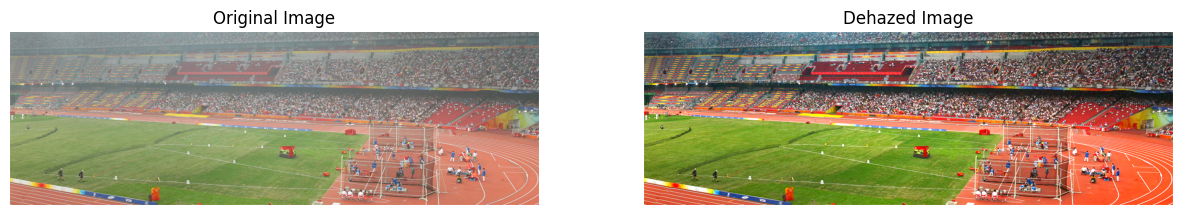

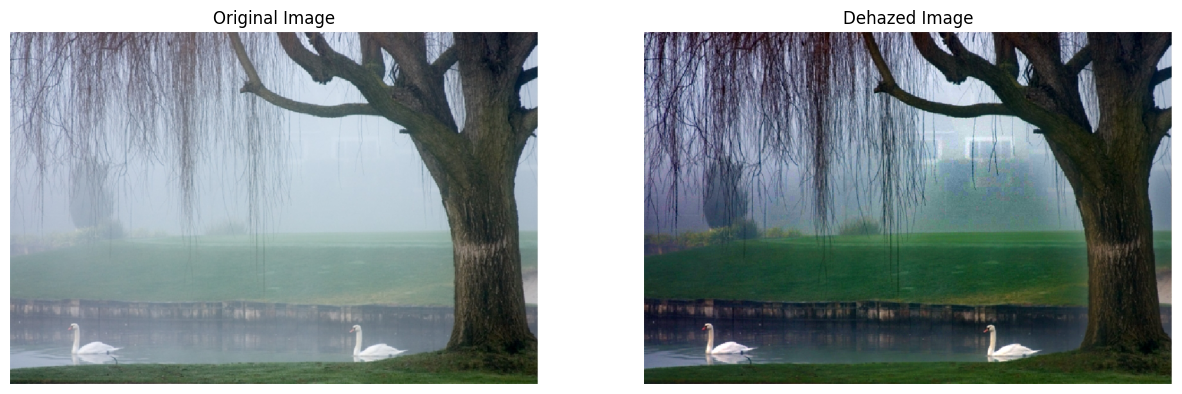

In [ ]:
image_paths = ["dataset/base/train/St_Wf_D_L__033.JPG"
    , "dataset/base/train/St_Wf_D_L__029.JPG"
    , "dataset/base/train/St_Wf_D_L__009.JPG"
    , "dataset/base/test/91.jpg"
    , "dataset/base/test/92.jpg"]
for image_path in image_paths:
    dehazed_img = dehaze(image_path)
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    image = cv2.imread(image_path)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(dehazed_img, cv2.COLOR_BGR2RGB))
    plt.title('Dehazed Image')
    plt.axis('off')

    plt.show()


# Process and Store Images

In [31]:
# dehaze image in dataset/base/train/ and dataset/base/test/ and store in dataset/dehazed/train/ and dataset/dehazed/test/
import os
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt

def dehaze_image(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for filename in os.listdir(input_dir):
        if filename.endswith(".JPG") or filename.endswith(".jpg"):
            image_path = os.path.join(input_dir, filename)
            dehazed_image = dehaze(image_path)
            output_path = os.path.join(output_dir, filename)
            cv2.imwrite(output_path, dehazed_image)
            print(f"Processed and saved: {output_path}")

# Process train and test datasets
dehaze_image("dataset/base/train", "dataset/dehazed/train")
dehaze_image("dataset/base/test", "dataset/dehazed/test")


Processed and saved: dataset/dehazed/train/1.jpg
Processed and saved: dataset/dehazed/train/10.jpg
Processed and saved: dataset/dehazed/train/100.jpg
Processed and saved: dataset/dehazed/train/10003688883_be11839091_z.jpg
Processed and saved: dataset/dehazed/train/10020320283_83b1514ef4_z.jpg
Processed and saved: dataset/dehazed/train/100309892_94978cd79e_z.jpg
Processed and saved: dataset/dehazed/train/100412171_55555c1ce0_z.jpg
Processed and saved: dataset/dehazed/train/101.jpg
Processed and saved: dataset/dehazed/train/101039_5ab416185b_z.jpg
Processed and saved: dataset/dehazed/train/102.jpg
Processed and saved: dataset/dehazed/train/10278173383_990d01a5eb_z.jpg
Processed and saved: dataset/dehazed/train/10367996104_44d1937338_z.jpg
Processed and saved: dataset/dehazed/train/1055104210_c386d6111c_z.jpg
Processed and saved: dataset/dehazed/train/10560349313_689e068235_z.jpg
Processed and saved: dataset/dehazed/train/10677419946_15c3d79e45_z.jpg
Processed and saved: dataset/dehazed/t

In [ ]:
import torch
import torch.nn.functional as F

class FeatureLossNetwork(torch.nn.Module):
    def __init__(self, feature_extractor):
        super(FeatureLossNetwork, self).__init__()
        self.feature_layers = feature_extractor
        self.layer_name_mapping = {
            '2': "conv1_2",
            '8': "conv2_2",
            '15': "conv3_3"
        }

    def extract_features(self, x):
        output = {}
        for name, module in self.feature_layers._modules.items():
            x = module(x)
            if name in self.layer_name_mapping:
                output[self.layer_name_mapping[name]] = x
        return list(output.values())

    def forward(self, predicted, ground_truth):
        loss = []
        predicted_features = self.extract_features(predicted)
        ground_truth_features = self.extract_features(ground_truth)
        for pred_feature, gt_feature in zip(predicted_features, ground_truth_features):
            loss.append(F.mse_loss(pred_feature, gt_feature))

        return sum(loss) / len(loss)